In [1]:
%matplotlib inline

# Build a neural network

Neural networks comprise of layers/modules that perform operations on data. 
The [torch.nn](https://pytorch.org/docs/stable/nn.html) namespace provides all the building blocks you need to 
build your own neural network. Every module in PyTorch subclasses the [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). 
A neural network is a module itself that consists of other modules (layers). This nested structure allows for
building and managing complex architectures easily.

In the following sections, we'll build a neural network to classify images in the FashionMNIST dataset.

In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
import matplotlib.pyplot as plt

## Get a hardware device for training

We want to be able to train our model on a hardware accelerator like the GPU, 
if it is available. Let's check to see if 
[torch.cuda](https://pytorch.org/docs/stable/notes/cuda.html) is available, else we 
continue to use the CPU.

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


## Define the class

We define our neural network by subclassing `nn.Module`, and 
initialize the neural network layers in `__init__`. Every `nn.Module` subclass implements
the operations on input data in the `forward` method.

In [5]:
import numpy as np

In [6]:
def factorial(n: int) -> int:
    """
    Compute n! recursively.
    :param n: an integer >= 0
    :returns: n!
    120
    """
    if n == 0:return 1
    return n*factorial(n-1)

In [7]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [8]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


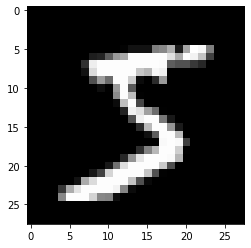

In [9]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [10]:
from typing import Tuple
class Card:
    def __init__(self, rank: str, suit: str) -> None:
        self.suit = suit
        self.rank = rank
        self.hard, self.soft = self._points()
    def _points(self) -> Tuple[int, int]:
        return int(self.rank), int(self.suit)

class AceCard(Card):
    def _points(self) -> Tuple[int, int]:
        return 1, 11
class FaceCard(Card):
    def _points(self) ->Tuple[int, int]:
        return 10, 10

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We create an instance of `NeuralNetwork`, and move it to the `device`, and print 
it's structure.



In [14]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


To use the model, we pass it the input data. This executes the model's `forward`,
along with some [background operations](https://github.com/pytorch/pytorch/blob/270111b7b611d174967ed204776985cefca9c144/torch/nn/modules/module.py#L866). 
Do not call `model.forward()` directly!

Calling the model on the input returns a 10-dimensional tensor with raw predicted values for each class.
We get the prediction densities by passing it through an instance of the `nn.Softmax` module.

In [15]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X) 
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([6])


## Model layers

Let's break down the layers in the FashionMNIST model. To illustrate it, we 
will take a sample minibatch of 3 images of size **28x28** and see what happens to it as 
we pass it through the network. 



In [16]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


### nn.Flatten

We initialize the [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) 
layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values (the minibatch dimension (at dim=0) is maintained).



In [17]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


### nn.Linear 

The [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
is a module that applies a linear transformation on the input using it's stored weights and biases.

In [18]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


### nn.ReLU

Non-linear activations are what create the complex mappings between the model's inputs and outputs.
They are applied after linear transformations to introduce *nonlinearity*, helping neural networks
learn a wide variety of phenomena.

In this model, we use [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) between our
linear layers, but there's other activations to introduce non-linearity in your model.

In [19]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[-2.4938e-01, -4.5850e-01,  4.9987e-01,  9.0356e-01,  2.6245e-01,
         -1.4256e-02, -2.8712e-01,  2.8336e-01,  1.3979e-01,  8.7160e-02,
          3.5938e-01, -9.3325e-02,  8.6614e-03,  7.2735e-02,  5.5163e-01,
          1.1419e-01,  1.5112e-01,  8.9534e-01, -4.1593e-01, -3.7403e-01],
        [-2.5913e-01, -2.9175e-01,  2.7409e-01,  6.3574e-01,  4.5578e-01,
          2.3010e-01, -1.4423e-01,  4.4936e-01,  6.3363e-02, -3.0219e-01,
          2.8100e-02, -2.3124e-01,  8.1526e-02,  1.2959e-01,  3.0456e-01,
          3.0422e-01,  2.2474e-01,  6.6529e-01, -1.3289e-01, -5.2771e-01],
        [-1.9867e-01, -1.7337e-01,  8.9944e-02,  1.0035e+00, -3.0140e-02,
          5.6101e-01, -1.4528e-01,  3.8370e-01, -7.5353e-04,  3.5472e-01,
         -2.3334e-01, -1.1789e-01, -1.3845e-01,  3.1567e-01,  2.9933e-01,
          1.7894e-01, -2.0807e-02,  6.3745e-01, -2.1783e-01, -5.7707e-01]],
       grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.0000, 0.4999, 0.9036, 0.2624,

### nn.Sequential

[nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) is an ordered 
container of modules. The data is passed through all the modules in the same order as defined. You can use
sequential containers to put together a quick network like `seq_modules`.



In [20]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

### nn.Softmax

The last linear layer of the neural network returns `logits` - raw values in \[`-infty`, `infty`] - which are passed to the
[nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) module. The logits are scaled to values \[0, 1\] representing the model's predicted densities for each class. `dim` parameter indicates the dimension along which the values must sum to 1.

In [21]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

## Model parameters

Many layers inside a neural network are *parameterized*, i.e. have associated weights 
and biases that are optimized during training. Subclassing `nn.Module` automatically 
tracks all fields defined inside your model object, and makes all parameters 
accessible using your model's `parameters()` or `named_parameters()` methods.

In this example, we iterate over each parameter, and print its size and a preview of its values.


In [22]:
print("Model structure: ", model, "\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure:  NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
) 


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0157,  0.0059, -0.0302,  ..., -0.0287,  0.0225,  0.0313],
        [ 0.0002, -0.0050, -0.0111,  ...,  0.0216, -0.0019, -0.0078]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([0.0341, 0.0221], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0345,  0.0279, -0.0111,  ..., -0.0119,  0.0326,  0.0054],
        [ 0.0168,  0.0046, -0.0166,  ..., -0.0134, -0.0079,  0.0396]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu

------------------

## Feedward Neural Network

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.datasets import make_moons
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras import activations
from time import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import norm, uniform, beta

In [3]:
X = np.vstack([norm.rvs(size = 1000) for _ in range(20)]).T
f = lambda x: np.log(np.linalg.norm(x, axis = 1))/10
y = f(X)

In [1]:
def create_model():
    model = Sequential()

    model.add(Dense(10, input_dim = 20, kernel_initializer='normal', activation='ReLU'))

    model.add(Dense(5, kernel_initializer='normal', activation='ReLU'))

    model.add(Dense(1, kernel_initializer='normal', activation='ReLU'))

    model.compile(loss = 'mean_absolute_error', optimizer ='adam', metrics = ['mean_absolute_error'])
    
    return model


Model:

$$f(x) = \sigma(XW + b)$$
where $\sigma$ = $\tanh = tan^{-1}$

* $W$ is matrix of $n$ x $1$, where $n$ is the numbers of columns 
* $b$ is a vector of $1$ dimenstion.
* Recall for the computation, $1$ convert in $m$, the numbers of rows. 

We can use other activation function like ReLU $f(x) = max(0, x)$

https://dafriedman97.github.io/mlbook/content/c3/s1/perceptron.html

In [5]:
#tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model_1 = create_model()
model_1.fit(X, y, epochs = 10, batch_size = 1 )#, callbacks=[tensorboard])

Epoch 1/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0186 - mean_absolute_error: 0.0186
Epoch 2/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0116 - mean_absolute_error: 0.0116
Epoch 3/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0111 - mean_absolute_error: 0.0111
Epoch 4/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0105 - mean_absolute_error: 0.0105
Epoch 5/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0102 - mean_absolute_error: 0.0102
Epoch 6/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0099 - mean_absolute_error: 0.0099
Epoch 7/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0096 - mean_absolute_error: 0.0096
Epoch 8/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0095 - mean_absolute_error: 0.0095
Epoch 9/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0096 - mean_absolu

In [7]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


In [8]:
for i,layer in enumerate(list(model_1.layers)):
    W, b = np.array(layer.weights[0]), np.array(layer.weights[1])
    print(f'W{i}:', W.shape,f'b{i}:', b.shape)

W0: (20, 10) b0: (10,)
W1: (10, 5) b1: (5,)
W2: (5, 1) b2: (1,)


In [9]:
20*10 + 10*5 + 5*1 + 16

271

In [112]:
# get the weights of the layer 0, the only layer

W, b = model_1.layers[0].get_weights()

In [113]:
# They are very similar

np.sum(np.tanh(X @ W + b) - model_1.predict(X))

1.274328277041381e-05

In [42]:
from sklearn import metrics

In [70]:
print(metrics.mean_absolute_error(y, model_1.predict(X).flatten()))
print(metrics.mean_absolute_percentage_error(y, model_1.predict(X).flatten()))

0.017837580952720523
0.12468702431768015


## For Classification

In [2]:
X, y = make_moons(n_samples=100, noise=0)

In [17]:
def create_model_bin():
    model = Sequential()

    model.add(Dense(1, input_dim = 2, kernel_initializer='normal', activation=activations.sigmoid))

    model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics = ['accuracy'])
    
    return model


In [18]:
# tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model_1 = create_model_bin()
model_1.fit(X, y, epochs = 100, batch_size = 1 )#, callbacks=[tensorboard])

Epoch 1/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6926 - accuracy: 0.5400
Epoch 2/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6689 - accuracy: 0.8300
Epoch 3/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6463 - accuracy: 0.8300
Epoch 4/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6253 - accuracy: 0.8200
Epoch 5/100
100/100 [==============================] - 0s 1ms/step - loss: 0.6056 - accuracy: 0.8300
Epoch 6/100
100/100 [==============================] - 0s 1ms/step - loss: 0.5874 - accuracy: 0.8200
Epoch 7/100
100/100 [==============================] - 0s 991us/step - loss: 0.5703 - accuracy: 0.8200
Epoch 8/100
100/100 [==============================] - 0s 1ms/step - loss: 0.5543 - accuracy: 0.8300
Epoch 9/100
100/100 [==============================] - 0s 1ms/step - loss: 0.5393 - accuracy: 0.8300
Epoch 10/100
100/100 [==============================] - 0s 1ms/step - loss: 0.5255 - accu

In [135]:
W, b = model_1.layers[0].get_weights()

In [149]:
y_hat = 1 / (1 +np.exp(-(X@W + b)))


In [156]:
X_1, X_2 = X[:, 0].copy(), X[:, 1].copy()

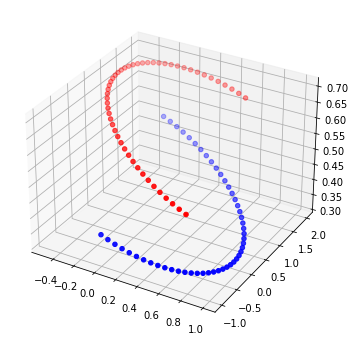

In [177]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm


fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(X_2[y==0], X_1[y==0], y_hat[y==0], color = 'b')
ax.scatter(X_2[y==1], X_1[y==1], y_hat[y==1], color = 'r')
plt.show()

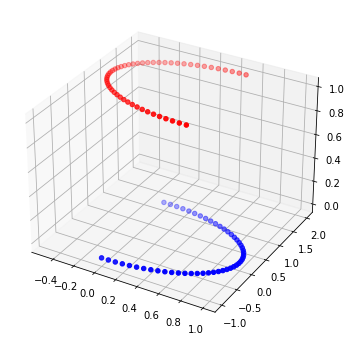

In [178]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm


fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(X_2[y==0], X_1[y==0], y[y==0], color = 'b')
ax.scatter(X_2[y==1], X_1[y==1], y[y==1], color = 'r')
plt.show()

# Simulation of data linearly separable

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import uniform, norm

In [3]:
np.random.seed(123)
X = np.vstack([norm.rvs(size = 200) for _ in range(2)]).T

In [4]:
np.random.seed(123)
B = np.random.randn(2)

In [51]:
z = lambda X,B: X @ B
def dot_prod(X, B):
    """ 
    X, B: numpy arrays
    dtype: float64
    """
    try:
        z = X@B
        return z
    except TypeError:
        if isinstance(X, str) or isinstance(B, str):
            print('The type of  X and B must be int or float')
    except ValueError:
        if (isinstance(X, str) and  not isinstance(B, str)) or (not isinstance(X, str) and isinstance(B, str)):
            print('The type of  X and B must be array data types')
        else:
            print('Other error')
        return None
    finally:
        print('The end')

In [56]:
def dot_prod(X, B):
    """ 
    X, B: numpy array
    dtype: float64
    """
    try:
        z = X@B
        return z
    except Exception as e:
        print(type(e))

In [6]:
h = lambda z:1/(1 + np.exp(-z))

In [7]:
y = np.where(h(z(X, B))>0.5, 1, 0)

In [8]:
color = np.where(y>0.5, 'b', 'r')

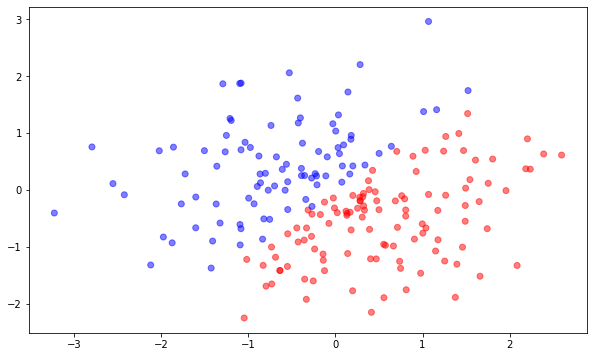

In [10]:
fig, ax = plt.subplots(figsize = (10, 6))

ax.scatter(X[:,0], X[:,1], c = color, alpha = 0.5)